# TINTOLib - Regression CNN

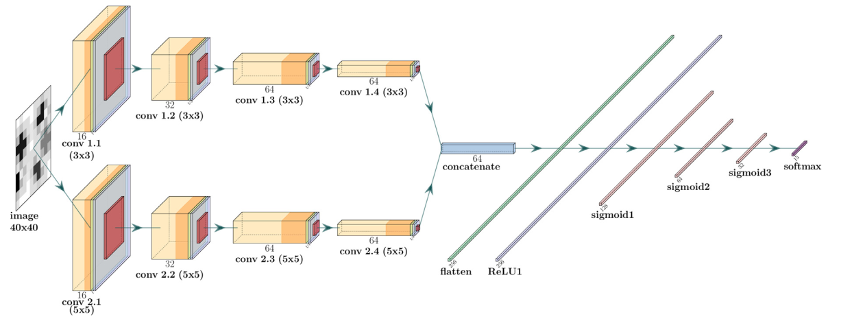

## Imports


In [1]:
# import sys
# print(sys.executable)

In [2]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
#import cv2
import gc
import matplotlib.pyplot as plt
#import openslide
#from openslide.deepzoom import DeepZoomGenerator
import tifffile as tifi
import sklearn
import tensorflow as tf
import seaborn as sns
from PIL import Image


from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score,mean_absolute_percentage_error

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adamax
from tensorflow.keras import layers, models, Model
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.layers import Input, Activation,MaxPooling2D, concatenate, AveragePooling2D, Concatenate
from keras.utils import plot_model
#from imblearn.over_sampling import RandomOverSampler

#Models of TINTOlib
from TINTOlib.barGraph import BarGraph
from TINTOlib.combination import Combination
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.supertml import SuperTML
from TINTOlib.tinto import TINTO
from TINTOlib.featureWrap import FeatureWrap
from TINTOlib.bie import BIE

# SET RANDOM SEED FOR REPRODUCIBILITY
SEED = 64
#torch.manual_seed(SEED)
#torch.cuda.manual_seed(SEED)
#torch.cuda.manual_seed_all(SEED)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-04-08 13:11:58.023353: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 13:11:58.034493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744110718.044829    1304 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744110718.048500    1304 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744110718.058652    1304 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Data Processing

### Read the dataset

In [3]:
dataset_name = 'boston'

#Read CSV
df = pd.read_csv(f"../resources/Datasets/{dataset_name}.csv")
df.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


In [4]:
df.shape

(506, 14)

- Extrameos cual será el tamaño cuadrático de la imagen

In [5]:
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

4


### Create images with TINTOLib

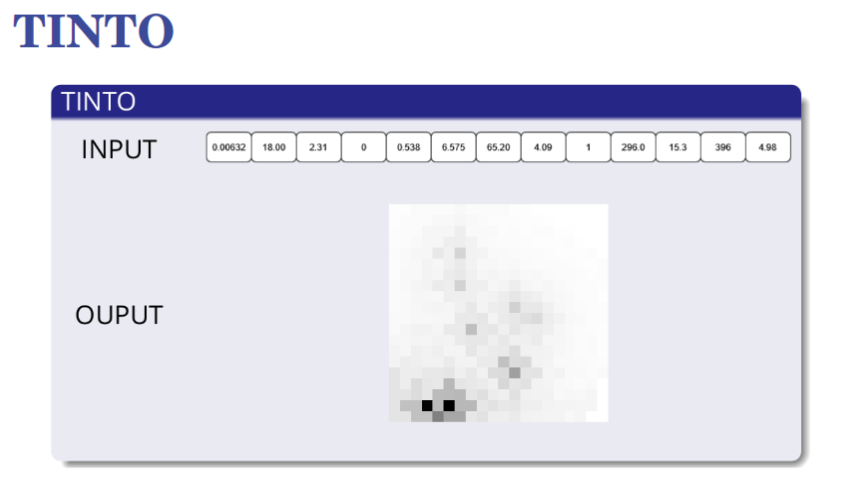

In [6]:
#Select the model and the parameters
#problem_type = "supervised"
problem_type = "regression"

# Transformation methods
image_model = TINTO(problem=problem_type, blur=True, option='maximum', pixels=20, random_seed=SEED)
name = f"TINTO_blur_maximum"

#Define the dataset path and the folder where the images will be saved
results_folder = f"Results/{dataset_name}_{name}"
images_folder = f"Synthetic_images/images_{dataset_name}_{name}"

## Generate images

In [7]:
import cv2
from sklearn.preprocessing import MinMaxScaler

X_train, X_val = train_test_split(df, test_size=0.20, random_state=SEED)
X_val, X_test = train_test_split(X_val, test_size=0.50, random_state=SEED)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

- Define a function to streamline the repetitive process of generating images, updating paths, and combining datasets:

In [8]:
def process_dataset(X, folder_name, generate_function, problem_type):
    """
    Handles dataset processing, including image generation, path updates, 
    and combining the dataset with image paths.

    Parameters:
    ----------
    X : DataFrame
        The dataset to process (training, validation, or test).
    
    folder_name : str
        The name of the folder where generated images will be stored 
        (e.g., 'train', 'val', 'test').
    
    generate_function : function
        The function used for training and generating images. It can be one of the following:
        - `fit`: Trains the model without generating images.
        - `fit_transform`: Trains the model and generates images for the dataset (used for training).
        - `transform`: Uses the pre-trained model to generate images for validation and testing.
    
    problem_type : str
        The type of problem being addressed (e.g., regression, supervised).
        This is used to locate the corresponding `.csv` file containing image paths.

    Returns:
    --------
    X_processed : DataFrame
        The dataset with updated image paths and raw tabular data, ready for further processing.
    
    y_processed : Series
        The labels corresponding to the dataset (target values).
    """
    # Generate the images if the folder does not exist
    folder_path = f"{images_folder}/{folder_name}"
    if not os.path.exists(folder_path):
        generate_function(X, folder_path)
    else:
        print(f"The images for {folder_name} are already generated")

    # Load image paths
    img_paths = os.path.join(folder_path, f"{problem_type}.csv")
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = folder_path + "/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X], axis=1)

    # Split data and labels
    X_processed = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_processed = combined_dataset["values"]

    return X_processed, y_processed

In [9]:
### X_train
X_train, y_train = process_dataset(X_train, "train", image_model.fit_transform, problem_type)

In [10]:
### X_val
X_val, y_val = process_dataset(X_val, "val", image_model.transform, problem_type)

In [11]:
### X_test
X_test, y_test = process_dataset(X_test, "test", image_model.transform, problem_type)

## Pre-modeling

In [12]:
#TIDY DATA SPLITTED
X_train_num = X_train.drop("images",axis=1)
X_val_num = X_val.drop("images",axis=1)
X_test_num = X_test.drop("images",axis=1)

#IMAGES
# For 3 channels (RGB)
X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

# For 1 channels (GRAY SCALE)
"""X_train_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_test["images"]])"""

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale numerical data
X_train_num = scaler.fit_transform(X_train_num)
X_val_num = scaler.transform(X_val_num)
X_test_num = scaler.transform(X_test_num)

attributes = X_train_num.shape[1]
height, width, channels = X_train_img[0].shape
imgs_shape = (height, width, channels)

print("Images shape: ",imgs_shape)
print("Attributres: ",attributes)
pixel=X_train_img[0].shape[0]
print("Image size (pixels):", pixel)

Images shape:  (20, 20, 3)
Attributres:  13
Image size (pixels): 20


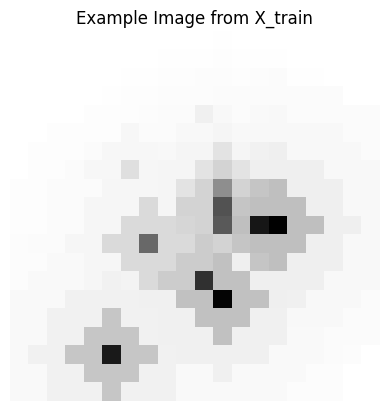

In [13]:
# Plot an example image (e.g., the first image in the array)
example_image = X_train_img[0]

# Convert the image from BGR (OpenCV default) to RGB for correct color display
example_image_rgb = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(example_image_rgb)
plt.title("Example Image from X_train")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()

In [14]:
# Normalitation
X_train_img = X_train_img/255
X_val_img = X_val_img/255
X_test_img = X_test_img/255

## Modeling with Regression CNN

In [15]:
dropout = 0.1

### **One-Branch CNN**

In [16]:
# Single branch CNN
#Input
input_shape = Input(shape=imgs_shape)

# CNN branch 1
tower_1 = Conv2D(16, (3,3), activation='relu',padding="same")(input_shape)
tower_1 = Activation('relu')(tower_1)
tower_1 = MaxPooling2D(2,2)(tower_1)

tower_1 = Conv2D(32, (3,3), activation='relu',padding="same")(tower_1)
tower_1 = Activation('relu')(tower_1)

tower_1 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1)
tower_1 = Activation('relu')(tower_1)

#Flatten
merged = Flatten()(tower_1)

#Dense layers
out = Dense(128, activation='relu')(merged)
out = Dense(64, activation='relu')(out)
out = Dense(32, activation='relu')(out)
out = Dense(1, activation="linear")(out)

model = Model(input_shape, out)

I0000 00:00:1744110720.294514    1304 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


### **Two-Branch CNN**

In [17]:
#Input
input_shape_2 = Input(shape=imgs_shape)

# CNN branch 1
tower_1_2 = Conv2D(16, (3,3), activation='relu',padding="same")(input_shape_2)
tower_1_2 = BatchNormalization()(tower_1_2)
tower_1_2 = Activation('relu')(tower_1_2)
tower_1_2 = MaxPooling2D(2,2)(tower_1_2)
tower_1_2 = Dropout(dropout)(tower_1_2)

tower_1_2 = Conv2D(32, (3,3), activation='relu',padding="same")(tower_1_2)
tower_1_2 = BatchNormalization()(tower_1_2)
tower_1_2 = Activation('relu')(tower_1_2)
tower_1_2 = MaxPooling2D(2,2)(tower_1_2)
tower_1_2 = Dropout(dropout)(tower_1_2)

tower_1_2 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1_2)
tower_1_2 = BatchNormalization()(tower_1_2)
tower_1_2 = Activation('relu')(tower_1_2)
tower_1_2 = MaxPooling2D(2,2)(tower_1_2)
tower_1_2 = Dropout(dropout)(tower_1_2)

tower_1_2 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1_2)
tower_1_2 = BatchNormalization()(tower_1_2)
tower_1_2 = Activation('relu')(tower_1_2)
tower_1_2 = MaxPooling2D(2,2)(tower_1_2)
tower_1_2 = Dropout(dropout)(tower_1_2)

#CNN branch 2
tower_2_2 = Conv2D(16, (5,5), activation='relu',padding="same")(input_shape_2)
tower_2_2 = BatchNormalization()(tower_2_2)
tower_2_2 = Activation('relu')(tower_2_2)
tower_2_2 = AveragePooling2D(2,2)(tower_2_2)
tower_2_2 = Dropout(dropout)(tower_2_2)

tower_2_2 = Conv2D(32, (5,5), activation='relu',padding="same")(tower_2_2)
tower_2_2 = BatchNormalization()(tower_2_2)
tower_2_2 = Activation('relu')(tower_2_2)
tower_2_2 = AveragePooling2D(2,2)(tower_2_2)
tower_2_2 = Dropout(dropout)(tower_2_2)

tower_2_2 = Conv2D(64, (5,5), activation='relu',padding="same")(tower_2_2)
tower_2_2 = BatchNormalization()(tower_2_2)
tower_2_2 = Activation('relu')(tower_2_2)
tower_2_2 = AveragePooling2D(2,2)(tower_2_2)
tower_2_2 = Dropout(dropout)(tower_2_2)

tower_2_2 = Conv2D(64, (5,5), activation='relu',padding="same")(tower_2_2)
tower_2_2 = BatchNormalization()(tower_2_2)
tower_2_2 = Activation('relu')(tower_2_2)
tower_2_2 = AveragePooling2D(2,2)(tower_2_2)
tower_2_2 = Dropout(dropout)(tower_2_2)

#Concatenate CNN branches
merged_2 = Concatenate(axis=1)([tower_1_2, tower_2_2])

#Flatten
merged_2 = Flatten()(merged_2)

#Dense layers
out_2 = Dense(512, activation='relu')(merged_2)
out_2 = Dropout(dropout)(merged_2)
out_2 = Dense(256, activation='relu')(out_2)
out_2 = Dropout(dropout)(out_2)
out_2 = Dense(128, activation='relu')(out_2)
out_2 = Dropout(dropout)(out_2)
out_2 = Dense(64, activation='relu')(out_2)
out_2 = Dropout(dropout)(out_2)
out_2 = Dense(32, activation="relu")(out_2)
out_2 = Dropout(dropout)(out_2)
out_2 = Dense(1, activation="linear")(out_2)

model_2 = Model(input_shape_2, out_2)

### Metrics

#### Define metrics and some hyperparameters

In [18]:
import tensorflow.keras.backend as K

def r_square(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2

METRICS = [
    tf.keras.metrics.MeanSquaredError(name = 'mse'),
    tf.keras.metrics.MeanAbsoluteError(name = 'mae'),
    tf.keras.metrics.RootMeanSquaredError(name = 'rmse'),
    r_square,
]

#### Print the hybrid model

In [19]:
os.makedirs(results_folder, exist_ok=True)

# Redirect the summary output to the specified file
with open(results_folder+"/model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    
with open(results_folder+"/model_summary_2.txt", "w") as f:
    model_2.summary(print_fn=lambda x: f.write(x + '\n'))

# Disable automatic matplotlib display
plt.ioff()
# Save the model plot
plot_model(model, to_file=results_folder+'model_plot.png', show_shapes=True, expand_nested=True)
plot_model(model_2, to_file=results_folder+'model_plot_2.png', show_shapes=True, expand_nested=True)
# Re-enable automatic matplotlib display (optional)
plt.ion()

### Compile


In [20]:
opt = Adam()

#### One-branch CNN

In [21]:
model.compile(
    loss="mse",
    optimizer=opt,
    metrics = METRICS
)

In [22]:
# Configure EarlyStopping for binary classification
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation accuracy
    min_delta=0.001,         # Minimum change in the monitored quantity to qualify as an improvement
    patience=20,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # Log when training stops
    mode='min',              # Maximize the accuracy; min the loss
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [23]:
model_history=model.fit(
    x=[X_train_img], y=y_train,
    validation_data=([X_val_img], y_val),
    epochs=100,
    batch_size=32,
    callbacks = [early_stopper]
)

Epoch 1/100


/home/pablost/DeepLearning_Synthetic_Images/.env/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(None, 20, 20, 3))',)
  warnings.warn(msg)
I0000 00:00:1744110722.900526    3884 service.cc:152] XLA service 0x7f048c00f7d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744110722.900553    3884 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-04-08 13:12:02.921171: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744110723.093861    3884 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-08 13:12:03.367096: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spille

 1/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - loss: 690.0276 - mae: 24.0718 - mse: 690.0276 - r_square: -5.2403 - rmse: 26.2684

I0000 00:00:1744110725.165616    3884 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-08 13:12:05.670353: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_414', 12 bytes spill stores, 12 bytes spill loads

2025-04-08 13:12:05.987397: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_414', 4 bytes spill stores, 4 bytes spill loads



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 433.9709 - mae: 18.6023 - mse: 433.9709 - r_square: -5.8377 - rmse: 20.6797

/home/pablost/DeepLearning_Synthetic_Images/.env/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(None, 20, 20, 3))',)
  warnings.warn(msg)
2025-04-08 13:12:07.863746: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_108', 12 bytes spill stores, 12 bytes spill loads

2025-04-08 13:12:08.164904: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_108', 4 bytes spill stores, 4 bytes spill loads



13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - loss: 424.9956 - mae: 18.3504 - mse: 424.9956 - r_square: -5.6857 - rmse: 20.4568 - val_loss: 67.6203 - val_mae: 6.2122 - val_mse: 67.6203 - val_r_square: -0.1899 - val_rmse: 8.2232
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 91.2845 - mae: 7.0134 - mse: 91.2845 - r_square: -0.2868 - rmse: 9.5259 - val_loss: 112.9582 - val_mae: 8.9257 - val_mse: 112.9582 - val_r_square: -1.2488 - val_rmse: 10.6282
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 109.8939 - mae: 8.4193 - mse: 109.8939 - r_square: -0.6875 - rmse: 10.4647 - val_loss: 60.2956 - val_mae: 5.7356 - val_mse: 60.2956 - val_r_square: -0.0083 - val_rmse: 7.7650
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 87.4616 - mae: 7.1225 - mse: 87.4616 - r_square: -0.2710 - rmse: 9.3403 - val_loss: 59.6923 - val_mae: 5.7141 - val_mse: 59.6923 - val_r_square: 0.0088 - val_rmse: 7.7261
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 79.4756 - mae: 6.5

In [24]:
print(model_history.history.keys())

dict_keys(['loss', 'mae', 'mse', 'r_square', 'rmse', 'val_loss', 'val_mae', 'val_mse', 'val_r_square', 'val_rmse'])


### Two-branch CNN

In [25]:
opt_2 = Adam()

In [26]:
model_2.compile(
    loss="mse",
    optimizer=opt_2,
    metrics = METRICS
)

In [27]:
# Configure EarlyStopping for binary classification
early_stopper_2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation accuracy
    min_delta=0.001,         # Minimum change in the monitored quantity to qualify as an improvement
    patience=20,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # Log when training stops
    mode='min',              # Maximize the accuracy; min the loss
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [28]:
model_history_2=model_2.fit(
    x=[X_train_img], y=y_train,
    validation_data=([X_val_img], y_val),
    epochs=100,
    batch_size=32,
    callbacks = [early_stopper_2]
)

Epoch 1/100


/home/pablost/DeepLearning_Synthetic_Images/.env/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_13
Received: inputs=('Tensor(shape=(None, 20, 20, 3))',)
  warnings.warn(msg)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 364.2075 - mae: 12.8906 - mse: 264.6221 - r_square: -4.6058 - rmse: 16.2356

/home/pablost/DeepLearning_Synthetic_Images/.env/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_13
Received: inputs=('Tensor(shape=(None, 20, 20, 3))',)
  warnings.warn(msg)


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 717ms/step - loss: 355.3592 - mae: 12.7917 - mse: 261.1117 - r_square: -4.4672 - rmse: 16.1244 - val_loss: 434.1969 - val_mae: 19.3337 - val_mse: 434.1969 - val_r_square: -8.1830 - val_rmse: 20.8374
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 99.7964 - mae: 7.8634 - mse: 99.7964 - r_square: -0.5006 - rmse: 9.9548 - val_loss: 481.8584 - val_mae: 20.5298 - val_mse: 481.8584 - val_r_square: -9.2387 - val_rmse: 21.9513
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 56.8722 - mae: 5.4119 - mse: 56.8722 - r_square: 0.2158 - rmse: 7.5075 - val_loss: 489.1690 - val_mae: 20.7051 - val_mse: 489.1690 - val_r_square: -9.4007 - val_rmse: 22.1172
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 51.5000 - mae: 5.5528 - mse: 51.5000 - r_square: 0.1841 - rmse: 7.1694 - val_loss: 498.3043 - val_mae: 20.9238 - val_mse: 498.3043 - val_r_square: -9.6028 - val_rmse: 22.3227
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 47.8063 

In [29]:
print(model_history_2.history.keys())

dict_keys(['loss', 'mae', 'mse', 'r_square', 'rmse', 'val_loss', 'val_mae', 'val_mse', 'val_r_square', 'val_rmse'])


## Results

### Train/Validation representation

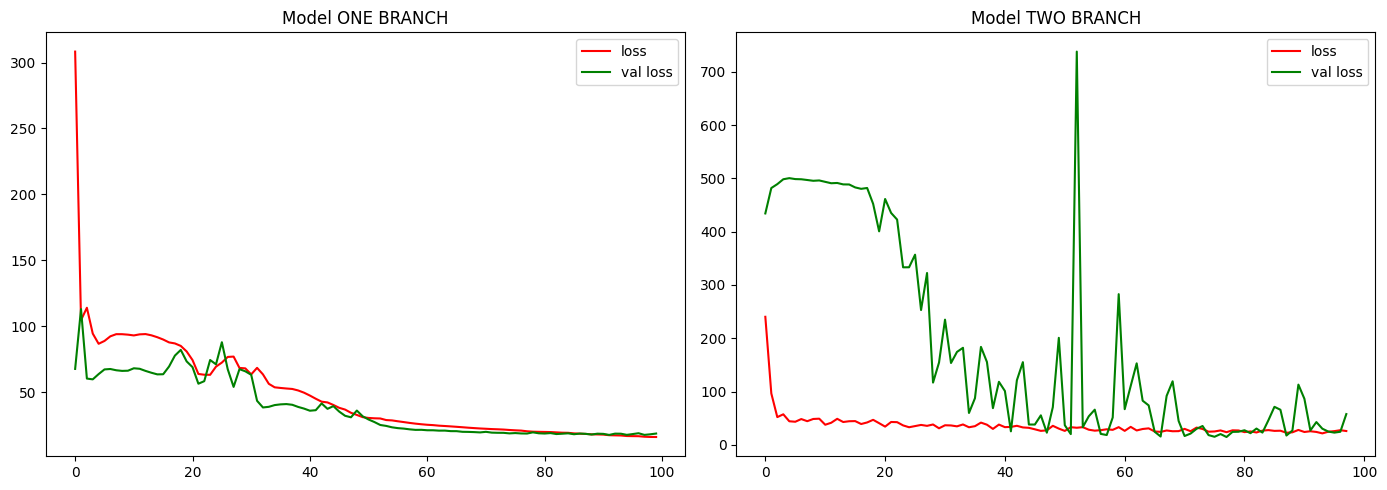

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Primer gráfico: Modelo ONE BRANCH
axes[0].plot(model_history.history['loss'], color='red', label='loss')
axes[0].plot(model_history.history['val_loss'], color='green', label='val loss')
axes[0].legend(loc='upper right')
axes[0].set_title('Model ONE BRANCH')

# Segundo gráfico: Modelo TWO BRANCH
axes[1].plot(model_history_2.history['loss'], color='red', label='loss')
axes[1].plot(model_history_2.history['val_loss'], color='green', label='val loss')
axes[1].legend(loc='upper right')
axes[1].set_title('Model TWO BRANCH')

plt.tight_layout()
plt.show()

### Train/Validation evaluation

In [31]:
score_test= model.evaluate([X_test_img], y_val)
score_test_2= model_2.evaluate([X_test_img], y_val)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 190.2399 - mae: 9.6673 - mse: 190.2399 - r_square: -1.4469 - rmse: 13.7927

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 188.2663 - mae: 9.7470 - mse: 188.2663 - r_square: -2.5720 - rmse: 13.7209
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 181.3073 - mae: 9.6529 - mse: 181.3073 - r_square: -2.7308 - rmse: 13.4622


In [32]:
prediction = model.predict([X_test_img])

test_mape = mean_absolute_percentage_error(y_test, prediction)
test_mae = mean_absolute_error(y_test, prediction)
test_mse = mean_squared_error(y_test, prediction)
test_rmse = root_mean_squared_error(y_test, prediction)
test_r2 = r2_score(y_test, prediction)

# Print the evaluation metrics
print("Mean Absolute Percentage Error:", test_mape)
print("Mean Absolute Error:", test_mae)
print("Mean Squared Error:", test_mse)
print("Root Mean Squared Error:", test_rmse)
print("R2 Score:", test_r2)

# Define the metrics and their values
metrics = {
    "Mean Absolute Percentage Error": test_mape,
    "Mean Absolute Error": test_mae,
    "Mean Squared Error": test_mse,
    "Root Mean Squared Error": test_rmse,
    "R2 Score": test_r2,
}

# Save the metrics to a text file
with open(f"{results_folder}/metrics.txt", "w") as file:
    for metric, value in metrics.items():
        file.write(f"{metric}: {value}\n")

print(f"Metrics saved to {results_folder}/metrics.txt")

/home/pablost/DeepLearning_Synthetic_Images/.env/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(32, 20, 20, 3))',)
  warnings.warn(msg)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step

/home/pablost/DeepLearning_Synthetic_Images/.env/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(None, 20, 20, 3))',)
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
Mean Absolute Percentage Error: 0.1463899261974975
Mean Absolute Error: 3.4049532983817308
Mean Squared Error: 35.1593195701952
Root Mean Squared Error: 5.929529456052579
R2 Score: 0.668815366569411
Metrics saved to Results/boston_TINTO_blur_maximum/metrics.txt


In [33]:
prediction_2 = model_2.predict([X_test_img])

test_mape_2 = mean_absolute_percentage_error(y_test, prediction_2)
test_mae_2 = mean_absolute_error(y_test, prediction_2)
test_mse_2 = mean_squared_error(y_test, prediction_2)
test_rmse_2 = root_mean_squared_error(y_test, prediction_2)
test_r2_2 = r2_score(y_test, prediction_2)

# Print the evaluation metrics
print("Mean Absolute Percentage Error:", test_mape_2)
print("Mean Absolute Error:", test_mae_2)
print("Mean Squared Error:", test_mse_2)
print("Root Mean Squared Error:", test_rmse_2)
print("R2 Score:", test_r2_2)

# Define the metrics and their values
metrics_2 = {
    "Mean Absolute Percentage Error": test_mape_2,
    "Mean Absolute Error": test_mae_2,
    "Mean Squared Error": test_mse_2,
    "Root Mean Squared Error": test_rmse_2,
    "R2 Score": test_r2_2,
}

# Save the metrics to a text file
with open(f"{results_folder}/metrics_2.txt", "w") as file:
    for metric, value in metrics_2.items():
        file.write(f"{metric}: {value}\n")

print(f"Metrics saved to {results_folder}/metrics_2.txt")

/home/pablost/DeepLearning_Synthetic_Images/.env/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_13
Received: inputs=('Tensor(shape=(32, 20, 20, 3))',)
  warnings.warn(msg)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step

/home/pablost/DeepLearning_Synthetic_Images/.env/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_13
Received: inputs=('Tensor(shape=(None, 20, 20, 3))',)
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Mean Absolute Percentage Error: 0.1182777464950523
Mean Absolute Error: 2.844136305416332
Mean Squared Error: 17.256375990967395
Root Mean Squared Error: 4.15407943965536
R2 Score: 0.8374528680653525
Metrics saved to Results/boston_TINTO_blur_maximum/metrics_2.txt
